# LSTM for time series forecasting
  

### Загрузка и предобработка данных

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv("../data/dataset/international-airline-passengers.csv", 
                      usecols = [1], 
                      engine = "python", 
                      skipfooter = 3)

In [4]:
data.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


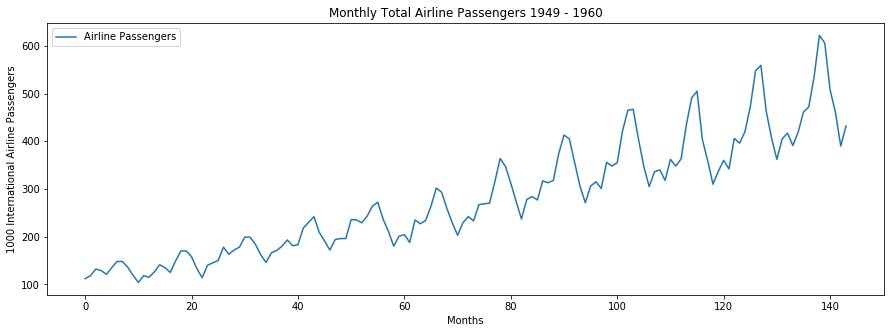

In [164]:
# Нарисуем
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

### Построение LSTM модели


In [165]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

#### Подготовим данные

In [166]:
# Будем рабоать с numpy.array.
data_raw = data.values.astype("float32")

# Нормализуем данные
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

dataset[0:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

#### Разобьем на трейн/тест

In [167]:
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (86, 58)


#### Получим матрицу лагов

In [168]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [169]:
# Получим матрицы лагов для трейна и для теста.
window_size = 24
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Сделаем reshape, чтобы преобразовать в тензор для keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(61, 24)
New training data shape:
(61, 1, 24)


#### Построим простую LSTM модель

Текущая архитектура будет состоять из следующих компонентов:

* Входной слой.
* Один LSTM слой из 4-х блоков.
* Один `Dense` слой для получения единственного выходного значения.
* RMSE в качестве функции потерь.

In [173]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(
        loss = "mean_squared_error", 
        optimizer = "adam"
    )
    model.fit(
        train_X, 
        train_Y, 
        epochs = 100, 
        batch_size = 1, 
        verbose = 2
    )
    
    return(model)

# Обучим модель.
model_ = fit_model(train_X, train_Y, window_size=24)

Epoch 1/100
 - 0s - loss: 0.0491
Epoch 2/100
 - 0s - loss: 0.0107
Epoch 3/100
 - 0s - loss: 0.0045
Epoch 4/100
 - 0s - loss: 0.0043
Epoch 5/100
 - 0s - loss: 0.0040
Epoch 6/100
 - 0s - loss: 0.0038
Epoch 7/100
 - 0s - loss: 0.0036
Epoch 8/100
 - 0s - loss: 0.0033
Epoch 9/100
 - 0s - loss: 0.0032
Epoch 10/100
 - 0s - loss: 0.0032
Epoch 11/100
 - 0s - loss: 0.0028
Epoch 12/100
 - 0s - loss: 0.0027
Epoch 13/100
 - 0s - loss: 0.0026
Epoch 14/100
 - 0s - loss: 0.0025
Epoch 15/100
 - 0s - loss: 0.0023
Epoch 16/100
 - 0s - loss: 0.0021
Epoch 17/100
 - 0s - loss: 0.0019
Epoch 18/100
 - 0s - loss: 0.0019
Epoch 19/100
 - 0s - loss: 0.0018
Epoch 20/100
 - 0s - loss: 0.0016
Epoch 21/100
 - 0s - loss: 0.0016
Epoch 22/100
 - 0s - loss: 0.0015
Epoch 23/100
 - 0s - loss: 0.0014
Epoch 24/100
 - 0s - loss: 0.0014
Epoch 25/100
 - 0s - loss: 0.0013
Epoch 26/100
 - 0s - loss: 0.0012
Epoch 27/100
 - 0s - loss: 0.0011
Epoch 28/100
 - 0s - loss: 0.0012
Epoch 29/100
 - 0s - loss: 0.0010
Epoch 30/100
 - 0s - lo

### Результаты


In [174]:
def predict_and_score(model, X, Y):
    # Предскажем и преобразуем данные обратно.
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    # Посчитаем RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model_, X=train_X, Y=train_Y)
rmse_test, test_predict = predict_and_score(model_, X=test_X, Y=test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 10.46 RMSE
Test data score: 36.92 RMSE


#### Plotting original data, predictions, and forecast

With a plot we can compare the predicted vs. actual passenger figures.

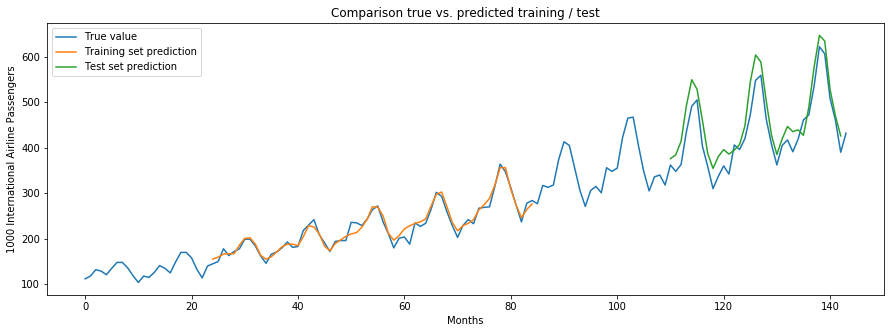

In [175]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


### Задание.

* Подобрать величину окна
* Изменить архитектуру LSTM, т.е. добавить больше слоев, нейронов и т.п.
* Подобрать гиперпараметры
* Сравнить качество работы модели с градиентным бустингом

## Полезные ссылки

* LSTM слайды https://www.slideshare.net/RalphSchlosser/lstm-tutorial
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://www.youtube.com/watch?v=56TYLaQN4N8
